# Getting Started With Baxter

This notebook demonstrates the simple control of a Baxter robot in the VREP simulator.

Examples include:

- reporting joint angles;
- setting joint angles explicitly;
- grabbing a camera snapshot from the end of arm cameras;
- retrieving the ultrasound sensor values.

## Set-Up

Import packages to control the simulator and enable widget controls in the notebook.

In [1]:
from ipywidgets import interact, interact_manual
import ipywidgets

from matplotlib import pyplot as plt
%matplotlib inline

import cv2
import numpy as np

import math

In [2]:
%run 'Set-up.ipynb'
%run 'Loading scenes.ipynb'


Load in the desired scene, in this case, containing an instance of the Baxter robot.

In [3]:
loadSceneRelativeToClient('../scenes/Baxter_demo.ttt')

In [4]:
from pyrep.vrep.vrep import simxGetObjectOrientation, simxGetObjectHandle, simxGetFloatSignal


In [12]:
rclass='Baxter_base'
print('Loading class: {}'.format(rclass))
class Baxter_base:

    def __init__(self, api: VRep):
        self._api = api
        self._joint1 = api.joint.with_position_control("Baxter_leftArm_joint4")
        #self._sensor_ultrasonic_left = api.sensor.proximity("Pioneer_p3dx_ultrasonicSensor3")
        #self._sensor_ultrasonic_right = api.sensor.proximity("Pioneer_p3dx_ultrasonicSensor6")
       
        res, self._handle = simxGetObjectHandle(self.id, 'Baxter', vrep.simx_opmode_oneshot_wait)
        
        self.joints= self._joints()
        self.sensors= self._joints()
        self.handles = self._introspect()
        self.names_by_handles = {self.handles[k]:k for k in self.handles}

    def _get_handle(self,name):
        res, handle=vrep.simxGetObjectHandle(self.id,
                                             name,
                                             vrep.simx_opmode_blocking)
        return handle
    
    def _introspect(self):
        #http://galvanicloop.com/blog/post/7/quadruped-robot-5-simulation-on-v-rep
        errorCode, handles, intData, \
        floatData, array = vrep.simxGetObjectGroupData(self.id,
                                                       vrep.sim_appobj_object_type,
                                                       0,
                                                       vrep.simx_opmode_oneshot_wait)
        return dict(zip(array, handles))
    
    def _joints(self):
        j = self._introspect()
        #Add arm joints
        joints={k: j[k] for k in j if 'joint' in k}
        #Add monitor joint
        joints['Baxter_monitorJoint']=j['Baxter_monitorJoint']
        return joints
    
    def _sensors(self):
        s = self._introspect()
        return {k: j[k] for k in s if 'ensor' in k}
    
    def get_joint_angle(self,jointname, degrees=False):
        handle=self.joints[jointname]
        res, pos = vrep.simxGetJointPosition(self.id,
                                                 handle,
                                                 vrep.simx_opmode_blocking)
        if degrees:
            pos = pos * 180 / math.pi
        return pos
        
    def joint_angles(self, degrees=False):
        ja = {}
        for j in sorted(self.joints):
            pos = self.get_joint_angle(j,degrees=degrees)
            ja[j] = pos
        return ja
    
'''
    def get_orientation(self):
        #http://www.coppeliarobotics.com/helpFiles/en/remoteApiFunctions.htm#simxGetObjectOrientation
        #Returns a value between +/-pi
        return simxGetObjectOrientation(self.id, self._handle, -1, v.simx_opmode_streaming)[1]
'''
        
print('This is a base class for the {} model\n'.format(eval(rclass).__name__ ))


Loading class: Baxter_base
This is a base class for the Baxter_base model



In [46]:
rclass='Baxter'
print('Loading class: {}'.format(rclass))
class Baxter(Baxter_base):

    def __init__(self, api: VRep):
        self._api = api
        self.id = api._id
        
        tmp1,tmp2=self.get_coords_left_tip(True),self.get_coords_right_tip(True)
        
        #Inherit init settings from parent class
        super(Baxter, self).__init__(api)

    def set_joint_angle(self, joint_name, angle):
        ''' Set the joint angle of a joint referred to by joint name '''
        #The joint angle is set by reference to the joint handle
        #Look-up the joint handle from the joint name
        handle=self.joints[joint_name]
        #res,handle = vrep.simxGetObjectHandle(self.id,'Baxter_rightArm_joint4',vrep.simx_opmode_oneshot_wait); 
        #Set the joint angle
        vrep.simxSetJointTargetPosition(self.id,
                                        handle,
                                        angle,
                                        vrep.simx_opmode_oneshot);
        
    def _get_coords_tip(self,arm,init=False):
        #simx_opmode_streaming (the first call) thence simx_opmode_buffer
        handle=self._get_handle('Baxter_{}Arm_tip'.format(arm))
        
        if init: mode= vrep.simx_opmode_buffer
        else: mode =vrep.simx_opmode_streaming
            
        res,pos=vrep.simxGetObjectPosition(self.id,handle,
                                           -1, mode)
        return pos

    def get_coords_left_tip(self, init=False):
        return self._get_coords_tip('left', init)
    
    def get_coords_right_tip(self,init=False):
        return self._get_coords_tip('right', init)
    
    def get_vision_sensor_image(self, vision_sensor_name):
        #http://www.forum.coppeliarobotics.com/viewtopic.php?f=9&t=7012&p=27786

        res, v1 = vrep.simxGetObjectHandle(self.id, vision_sensor_name, vrep.simx_opmode_oneshot_wait)
        err, resolution, image = vrep.simxGetVisionSensorImage(self.id, v1, 0, vrep.simx_opmode_streaming)
        img=None
        while err!=vrep.simx_return_ok:#(vrep.simxGetConnectionId(clientID) != -1):
            err, resolution, image = vrep.simxGetVisionSensorImage(self.id, v1, 0, vrep.simx_opmode_buffer)
            if err == vrep.simx_return_ok:
                #print("image OK!!!")
                img = np.array(image,dtype=np.uint8)
                #
                img.resize([resolution[1],resolution[0],3])
                #For some reason the image is upside down unless we flip it?
                img = cv2.flip(img,0)
                ok=False
            elif err == vrep.simx_return_novalue_flag:
                #print("no image yet")
                pass
            else:
                print(err)
        return img
    
    def get_ultrasonic_sensor_reading(self, ultrasonic_sensor_number):
        if '{}'.format(ultrasonic_sensor_number).isdigit() and int(ultrasonic_sensor_number) > 0 and int(ultrasonic_sensor_number)<13: 
            ultrasonic_sensor_number=int(ultrasonic_sensor_number)
        else: return "Not a valid input: expecting int in range 1..12"
        handle = self._get_handle('Baxter_ultrasonic_sensor{}'.format(ultrasonic_sensor_number))
        err, detectionState,detectedPoint,detectedObjectHandle,detectedSurfaceNormalVector=vrep.simxReadProximitySensor(self.id,handle,vrep.simx_opmode_streaming)
        while err!=vrep.simx_return_ok:
            err, detectionState,detectedPoint,detectedObjectHandle,detectedSurfaceNormalVector=vrep.simxReadProximitySensor(self.id,handle,vrep.simx_opmode_buffer)
        if not detectionState:
            return False
        distance=math.sqrt(detectedPoint[0]*detectedPoint[0]+detectedPoint[1]*detectedPoint[1]+detectedPoint[2]*detectedPoint[2])
        return distance, self.names_by_handles[detectedObjectHandle], detectedPoint, detectedSurfaceNormalVector

methods = [method for method in dir(eval(rclass)) if not method.startswith('_')]
print('Methods available in {}:\n\t{}\n'.format(eval(rclass).__name__ , '\n\t'.join(methods)))        


Loading class: Baxter
Methods available in Baxter:
	get_coords_left_tip
	get_coords_right_tip
	get_joint_angle
	get_ultrasonic_sensor_reading
	get_vision_sensor_image
	joint_angles
	set_joint_angle



## Cameras

The Baxter has 3 cameras:

- a camera on the end of each arm;
- a camera in the monitor; if enabled (`headCameraOn=true` in the non-threaded child script), the view from the monitor camera is displayed in the monitor. *(I'm not sure how to edit the screen or how the camera view is attached to it?)*

To enable the arm cameras, enable the non-threaded script and in the script switch the desired cameras on:

- `local headCameraOn=false`
- `local rightHandSensorsOn=true`
- `local leftHandSensorsOn=true`

## Ultrasound sensor

To enable the ultrasound sensors placed around the head, enable the non-threaded script and in the script, enable the head sensor:

- `local headSensorOn=true`

## Controlling the Robot

To begin with, ensure that no simulation is currently running, then create a Python object that maps on to the simulated Baxter robot.

In [48]:
from pyrep import VRep
from pyrep.vrep import vrep as vrep

#Ensure there are no outstanding simulations running
vrep.simxFinish(-1)

#Open  connection to the simulator
api=VRep.connect("127.0.0.1", 19997)

In [49]:
#Start the simulation
api.simulation.start()

#Create a Python object to represent the simulated robot
r = Baxter(api)

### Grab a Snapshot from the Cameras

The Baxter robot has three cameras, one at the end of each arm and one mounted in the monitor (face).

By default, the arm cameras are enabled in the model we will use, and the head/monitor camera is disabled.

We can grab a snapshot from a camera and display it in the notebook.

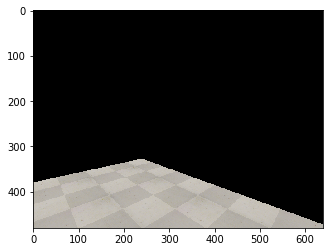

In [50]:
plt.imshow( r.get_vision_sensor_image('Baxter_rightArm_camera') );

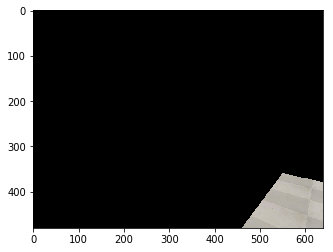

In [109]:
plt.imshow( r.get_vision_sensor_image('Baxter_leftArm_camera') );

## Controlling Baxter's Joints

The Baxter robot (without manipulators attached) has 7 degrees of freedom on each arm and one degree of freedom on its head, which allows it to turn the monitor from side to side.

![](../images/V-REP_PRO_EDU_-_baxter_joints.png)

We can get get the joint angles back in radians:

In [68]:
r.joint_angles()

{'Baxter_leftArm_joint1': 0.0,
 'Baxter_leftArm_joint2': 0.00028061866760253906,
 'Baxter_leftArm_joint3': -4.76837158203125e-07,
 'Baxter_leftArm_joint4': 0.00012636184692382812,
 'Baxter_leftArm_joint5': -7.152557373046875e-07,
 'Baxter_leftArm_joint6': 6.437301635742188e-05,
 'Baxter_leftArm_joint7': 0.0,
 'Baxter_monitorJoint': 0.0,
 'Baxter_rightArm_joint1': 9.5367431640625e-07,
 'Baxter_rightArm_joint2': 0.00014925003051757812,
 'Baxter_rightArm_joint3': 2.384185791015625e-07,
 'Baxter_rightArm_joint4': -4.76837158203125e-07,
 'Baxter_rightArm_joint5': 9.5367431640625e-07,
 'Baxter_rightArm_joint6': -4.76837158203125e-07,
 'Baxter_rightArm_joint7': 0.0}

In [69]:
r.joint_angles(degrees=True)

{'Baxter_leftArm_joint1': 0.0,
 'Baxter_leftArm_joint2': 0.016078265306210017,
 'Baxter_leftArm_joint3': -2.7320756680051004e-05,
 'Baxter_leftArm_joint4': 0.007171698628513389,
 'Baxter_leftArm_joint5': 1.3660378340025502e-05,
 'Baxter_leftArm_joint6': 0.0036883021518068857,
 'Baxter_leftArm_joint7': 0.0,
 'Baxter_monitorJoint': 0.0,
 'Baxter_rightArm_joint1': 5.464151336010201e-05,
 'Baxter_rightArm_joint2': 0.008551396840855964,
 'Baxter_rightArm_joint3': 1.3660378340025502e-05,
 'Baxter_rightArm_joint4': -4.0981135020076506e-05,
 'Baxter_rightArm_joint5': 5.464151336010201e-05,
 'Baxter_rightArm_joint6': 0.0,
 'Baxter_rightArm_joint7': 0.0}

The joint angles in the model can be set with reference to the joint angle name. 

Create a simple test to allow us to check that joint selection and control works. The command will only be issued when the *Run Interact* button is pressed.

In [60]:
def f(j, x):
    r.set_joint_angle(j,x)
    
interact_manual(f, j=['Baxter_leftArm_joint1',
                      'Baxter_leftArm_joint2',
                      'Baxter_monitorJoint'],
                x=(-2,2,0.2));

A Jupyter Widget

We can iterate through the joint names to create a widget for each one:

In [ ]:
posDisplay = ipywidgets.Text()



for j in r.joints:
    exec("""
def {j}({js}):
    r.set_joint_angle('{j}',{js})
    posDisplay.value=','.join([str(x) for x in r.get_coords_left_tip()])+ ','.join([str(x) for x in r.get_coords_right_tip()])
interact({j}, {js}=(-3.5,3.5,0.2))
""".format(j=j, js='_'.join(j.split('_')[1:]).replace('Arm_joint','')))
posDisplay

In [48]:
','.join([str(x) for x in r.get_coords_left_tip()])+ ','.join([str(x) for x in r.get_coords_right_tip()])

'-2.979215383529663,1.7465461492538452,1.2629362344741821-2.6313071250915527,0.21917463839054108,0.6749176979064941'

In [287]:
r.get_coords_left_tip(), r.get_coords_right_tip()

([-1.562764286994934, 1.683702826499939, 1.1301542520523071],
 [-1.4352781772613525, -0.1563175916671753, 1.3918207883834839])

### Find Joint Angle Range

We need to put some of the prior joints into a position that allows maximum freedom for later joints. eg Joint4 benefits from Joint2 being angled back.

In [180]:
joints_range={}
for j in r.joints:
    r.set_joint_angle(j,0)
    
for j in r.joints:
    joint_min=999
    joint_max=-999
    joint_curr=0
    print('Looking for max {}...'.format(j))
    r.set_joint_angle(j,0)
    if j.endswith('joint4'):
        r.set_joint_angle(j.replace('4','2'),-1)
    while True:
        joint_curr=r.get_joint_angle(j,True)
        if joint_curr>joint_max:
            joint_max=joint_curr
            r.set_joint_angle(j,joint_curr+0.1)
            time.sleep(0.1)
        else:
            r.set_joint_angle(j,0)
            break
    print('Looking for min {}...'.format(j))
    while True:
        joint_curr=r.get_joint_angle(j,True)
        if joint_curr<joint_min:
            joint_min=joint_curr
            r.set_joint_angle(j,joint_curr-0.1)
            time.sleep(0.1)
        else:
            r.set_joint_angle(j,0)
            break
    joints_range[j]=(joint_min,joint_max)

Looking for max Baxter_rightArm_joint1...
Looking for min Baxter_rightArm_joint1...
Looking for max Baxter_rightArm_joint2...
Looking for min Baxter_rightArm_joint2...
Looking for max Baxter_rightArm_joint3...
Looking for min Baxter_rightArm_joint3...
Looking for max Baxter_rightArm_joint4...
Looking for min Baxter_rightArm_joint4...
Looking for max Baxter_rightArm_joint5...
Looking for min Baxter_rightArm_joint5...
Looking for max Baxter_rightArm_joint6...
Looking for min Baxter_rightArm_joint6...
Looking for max Baxter_rightArm_joint7...
Looking for min Baxter_rightArm_joint7...
Looking for max Baxter_leftArm_joint1...
Looking for min Baxter_leftArm_joint1...
Looking for max Baxter_leftArm_joint2...
Looking for min Baxter_leftArm_joint2...
Looking for max Baxter_leftArm_joint3...
Looking for min Baxter_leftArm_joint3...
Looking for max Baxter_leftArm_joint4...
Looking for min Baxter_leftArm_joint4...
Looking for max Baxter_leftArm_joint5...
Looking for min Baxter_leftArm_joint5...
Lo

In [181]:
joints_range

{'Baxter_leftArm_joint1': (-1.6980311870574951, 1.7053349018096924),
 'Baxter_leftArm_joint2': (-2.147843599319458, 1.0465214252471924),
 'Baxter_leftArm_joint3': (-3.05545711517334, 3.0528998374938965),
 'Baxter_leftArm_joint4': (-0.04999184608459473, 2.6179652214050293),
 'Baxter_leftArm_joint5': (-3.0589990615844727, 3.059000253677368),
 'Baxter_leftArm_joint6': (-1.5753512382507324, 2.089462995529175),
 'Baxter_leftArm_joint7': (-3.0691978931427, 3.0487866401672363),
 'Baxter_monitorJoint': (-1.5717580318450928, 1.569875955581665),
 'Baxter_rightArm_joint1': (-1.6986820697784424, 1.6308674812316895),
 'Baxter_rightArm_joint2': (-2.1467416286468506, 1.0474610328674316),
 'Baxter_rightArm_joint3': (-3.0534327030181885, 3.0549230575561523),
 'Baxter_rightArm_joint4': (-0.05036044120788574, 2.6176369190216064),
 'Baxter_rightArm_joint5': (-3.058709144592285, 3.059293270111084),
 'Baxter_rightArm_joint6': (-1.5675172805786133, 2.097275733947754),
 'Baxter_rightArm_joint7': (-3.068850278

### Activity

Use the above sliders to try to move the end effector to a range of different target positions.

In [183]:
for j in joints_range:
    min_joint,max_joint=joints_range[j]
    print('{}: ({}, {})'.format(j, min_joint * 180 / math.pi,
                       max_joint * 180 / math.pi))

Baxter_rightArm_joint1: (-97.32731333285196, 93.44182361970681)
Baxter_rightArm_joint2: (-122.9992350265052, 60.01509638771784)
Baxter_rightArm_joint3: (-174.9488069101651, 175.0341979351686)
Baxter_rightArm_joint4: (-2.8854407356285665, 149.97954775756608)
Baxter_rightArm_joint5: (-175.2511247432082, 175.28459267014128)
Baxter_rightArm_joint6: (-89.81212449097863, 120.16504803040841)
Baxter_rightArm_joint7: (-175.8321689359012, 174.70308402458474)
Baxter_leftArm_joint1: (-97.29002049998368, 97.70849253005203)
Baxter_leftArm_joint2: (-123.0623732951928, 59.9612608366798)
Baxter_leftArm_joint3: (-175.06479718265027, 174.91827596457514)
Baxter_leftArm_joint4: (-2.8643217907148872, 149.9983580985403)
Baxter_leftArm_joint5: (-175.26773576326968, 175.26780406516139)
Baxter_leftArm_joint6: (-90.26097720247519, 119.71741109258411)
Baxter_leftArm_joint7: (-175.85208576752095, 174.68260711745302)
Baxter_monitorJoint: (-90.05510164051266, 89.9472666138965)


## Ultrasound Sensors

There are 12 ultrasound sensors mounted on the head of the Baxter robot, numbered 1 to 12; sensor 1 is in the front of Baxtr's head pointing forward, and the other sensors are number counting clockwise: sensor 4 is above Baxter's right "ear", sensor 7 in the center of the back of its head, sensor 10 above its left "ear".

A convenience function is defined that returns:

- `False` if nothing is detected;
- the Cartesian distance to the detected object in meters
- the name of the detected object
- the relative co-ords (`[x,y,z]`) of the detected object
- the normal vector to the detected object

In [54]:
r.get_ultrasonic_sensor_reading(3)

(0.6424231500656177,
 'Baxter_rightArm_link4_visible',
 [3.259629011154175e-08, -0.1662713587284088, 0.6205331087112427],
 [0.15524740517139435, 0.9413827657699585, -0.29949435591697693])

## Stop the Simulation and Close the Simulator Connection

In [55]:
#Stop the simulation
api.simulation.stop()

#Close the scene
vrep.simxCloseScene(api.simulation._id,vrep.simx_opmode_blocking)

#Close the connection to the simulator
api.close_connection()

## Possible things to do...

If you add an object to the scene - eg a chair - and move it around, you should see that the ultrasound detectors are able to detect it.